## libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import sys
sys.path.append(os.path.abspath('../'))

os.environ['TRANSFORMERS_CACHE'] = '../hfcache'
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [3]:
import json, torch, gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import umap
import umap.plot

from transformers import AutoModel, AutoTokenizer

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, adjusted_rand_score,
    normalized_mutual_info_score
)

In [4]:
from src.embedders.get_embeddings import get_embeddings

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cache_dir = '../hfcache'
data_dir = '../data'

## dataset

In [6]:
dataset_file = 'sample_summaries.csv'
dataset_path = os.path.join(data_dir, dataset_file)
data = pd.read_csv(dataset_path)

In [7]:
data.head(1)

,tag,summary
0,cs,The goal of this paper is to define and analyz...


In [8]:
# encode the tags
str_idx_map = {}
for idx, tag in enumerate(data.tag.unique()):
    str_idx_map[tag] = idx
    
true_labels = data['tag'].tolist()

for idx in range(len(true_labels)):
    true_labels[idx] = str_idx_map[true_labels[idx]]

In [9]:
def tag_embeddings_to_json(tags: list[str],
                           embeddings: list[list],
                           filename: str = os.path.join(data_dir, 'embeddings.json')
                          ) -> list[dict]:
    combined_data = [{'tag': tag, 'embedding': emb} for tag, emb in zip(tags, embeddings)]
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(combined_data, f, indent=4)

## models

In [10]:
model_names = [
    ('allenai/scibert_scivocab_uncased', 'scibert'),
    ('T-Systems-onsite/cross-en-de-roberta-sentence-transformer', 'roberta'),
    ('jinaai/jina-embeddings-v3', 'jina')
]

In [ ]:
results = {'tags': data['tag'].tolist()}
for model_name in model_names:
    model = AutoModel.from_pretrained(model_name[0], trust_remote_code=True, cache_dir=cache_dir).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name[0], cache_dir=cache_dir)
    
    embeddings = get_embeddings(model, tokenizer, data['summary'].tolist()).to(torch.float32).cpu().numpy()
    results[model_name[1]] = embeddings
    
    save_path = os.path.join(data_dir, f'{model_name[1]}.json')
    tag_embeddings_to_json(data['tag'].tolist(), embeddings.tolist(), save_path)
    
    gc.collect()
    torch.cuda.empty_cache()

Processing batches: 100%|███████████████████████████████████████████████████████████| 282/282 [00:55<00:00,  5.12it/s]
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch na

## metrics of clustering

In [12]:
for model_name in model_names:
    embeddings = results[model_name[1]]
    
    kmeans = KMeans(n_clusters=9, random_state=0, n_init='auto').fit(embeddings)
    predicted_labels = kmeans.predict(embeddings)
    
    score = silhouette_score(embeddings, predicted_labels)
    ari_score = adjusted_rand_score(true_labels, predicted_labels)
    nmi_score = normalized_mutual_info_score(true_labels, predicted_labels)
    
    print(f'Silhouette Score for {model_name[1]}: {np.round(score, 4)}')
    print(f'Adjusted Rand Index for {model_name[1]}: {np.round(ari_score, 4)}')
    print(f'Normalized Mutual Information Score for {model_name[1]}: {np.round(nmi_score, 4)}\n')

Silhouette Score for scibert: 0.09070000052452087
Adjusted Rand Index for scibert: 0.1145
Normalized Mutual Information Score for scibert: 0.1748

Silhouette Score for roberta: 0.0035000001080334187
Adjusted Rand Index for roberta: 0.2259
Normalized Mutual Information Score for roberta: 0.3099

Silhouette Score for jina: 0.035999998450279236
Adjusted Rand Index for jina: 0.7183
Normalized Mutual Information Score for jina: 0.7367



## plot the clusters

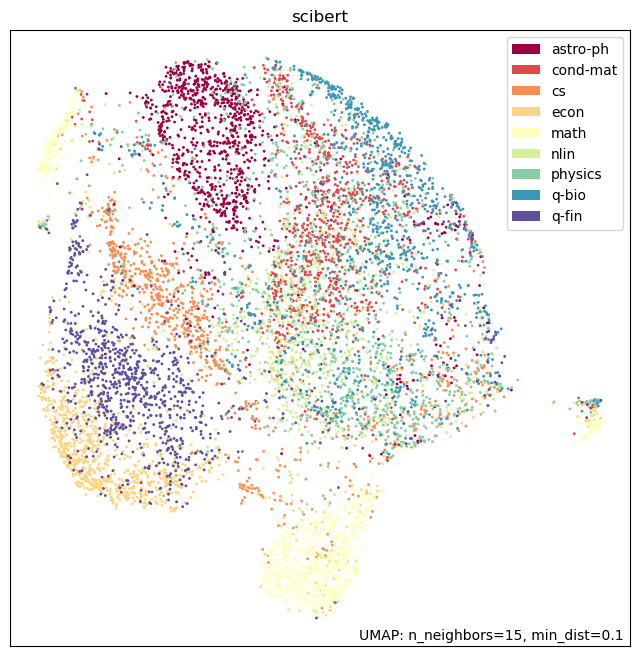

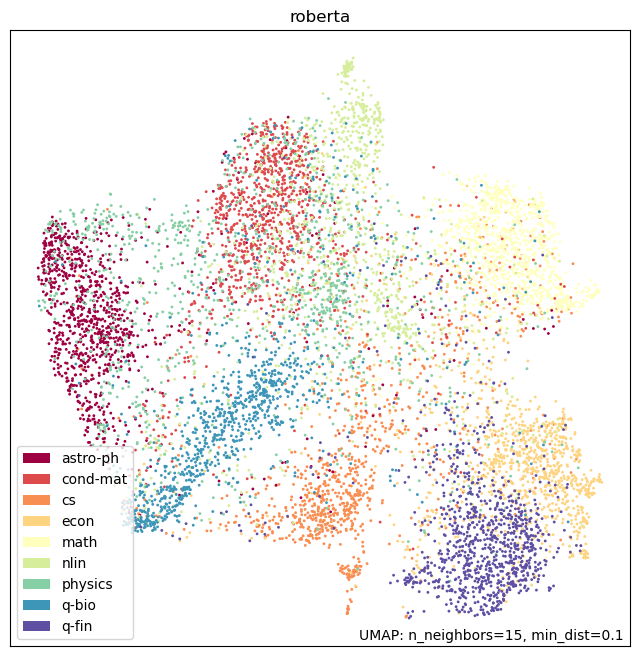

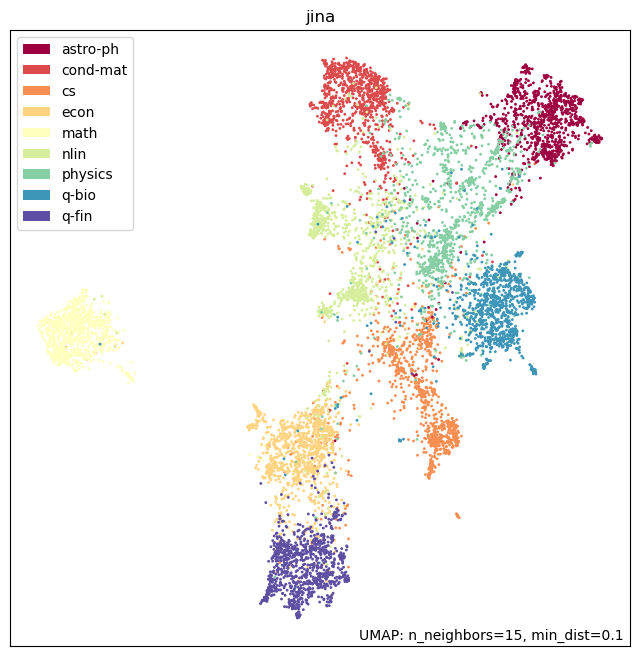

In [20]:
for model_name in model_names:
    embeddings = results[model_name[1]]
    
    mapper = umap.UMAP().fit(embeddings)
    umap.plot.points(mapper, labels=data['tag'].to_numpy())

    plt.title(f'{model_name[1]}')
    plt.show()